In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
def preprocess(df):
    data = df.values
    X = data[:,0:10]
    y = data[:,10]
    #we have to scale the features to a common range
    #we are using min-max scaler instead of standardscaler because min-max scaler preserves the distribution of the data
    X = preprocessing.MinMaxScaler().fit_transform(X)
    return X,y

In [3]:
def split(X,y):
    X_train, temp_x, y_train, temp_y = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(temp_x, temp_y, test_size=0.5)
    return X_train,X_val,X_test,y_train,y_val,y_test

In [4]:
def nnetwork(n1 = 32,n2 = 32,n3 = 32,n4 = 32):
    model = Sequential()
    model.add(Dense(n1,activation = 'relu',input_shape = (10,))) #The weight matrix is initialised using the default initializer 'glorot_uniform'
    model.add(Dense(n2,activation = 'relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(Dense(n3,activation = 'relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(Dense(n4,activation = 'relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(Dense(1,activation = 'sigmoid'))
    # model.summary()
    return model    

In [5]:
#This is for learning rate scheduler.
#decay_rate is hyperparameter that we need to optimize
#we can use different typer decays:
# time based decay: lr = lr/(1 + decay_rate*epoch)
# step decay: lr = lr0*drop^(floor(epoch/epoch_drop))
#The following is exponential decay:
def schedule(epoch,lr,decay_rate = 0.005):
    if(epoch < 10):
        return lr
    # lr_new = lr*np.exp(-decay_rate*epoch)
    lr_new = lr*np.exp(-decay_rate)
    # lr_new = lr/(1 + decay_rate*epoch)
    return lr_new

In [6]:
def train(model,X_train,y_train,X_val,y_val,num_epochs = 500,batch_size = 32,lr_initial = 0.001,momentum = 0.5,patience_value = 7):
    tf.keras.backend.clear_session()
    callbacks = [EarlyStopping(monitor='val_acc', patience=patience_value),LearningRateScheduler(schedule)]
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr_initial,momentum= momentum),metrics=['acc'])
    model_history=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val),
                        callbacks=callbacks)
    return model,model_history

In [7]:
df = pd.read_csv('housepricedata.csv')

In [8]:
np.random.seed(42)

In [9]:
X,y = preprocess(df)

In [10]:
X_train,X_val,X_test,y_train,y_val,y_test = split(X,y)

In [11]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1022, 10) (219, 10) (219, 10) (1022,) (219,) (219,)


In [24]:
#Always run the following two line together
model = nnetwork(16,32,32,16) 
model,model_hist = train(model,X_train,y_train,X_val,y_val,num_epochs = 500,batch_size = 32,lr_initial = 0.01,momentum = 0.5,patience_value = 35)

Epoch 1/500
32/32 [==============================] - 1s 24ms/step - loss: 1.4368 - acc: 0.6820 - val_loss: 1.4240 - val_acc: 0.7215 - lr: 0.0100
Epoch 2/500
32/32 [==============================] - 0s 6ms/step - loss: 1.4136 - acc: 0.7055 - val_loss: 1.4014 - val_acc: 0.7352 - lr: 0.0100
Epoch 3/500
32/32 [==============================] - 0s 5ms/step - loss: 1.3910 - acc: 0.7162 - val_loss: 1.3795 - val_acc: 0.6758 - lr: 0.0100
Epoch 4/500
32/32 [==============================] - 0s 5ms/step - loss: 1.3688 - acc: 0.7055 - val_loss: 1.3575 - val_acc: 0.7078 - lr: 0.0100
Epoch 5/500
32/32 [==============================] - 0s 5ms/step - loss: 1.3476 - acc: 0.7114 - val_loss: 1.3363 - val_acc: 0.7260 - lr: 0.0100
Epoch 6/500
32/32 [==============================] - 0s 6ms/step - loss: 1.3266 - acc: 0.7309 - val_loss: 1.3150 - val_acc: 0.7580 - lr: 0.0100
Epoch 7/500
32/32 [==============================] - 0s 6ms/step - loss: 1.3057 - acc: 0.7446 - val_loss: 1.2935 - val_acc: 0.7808 - lr

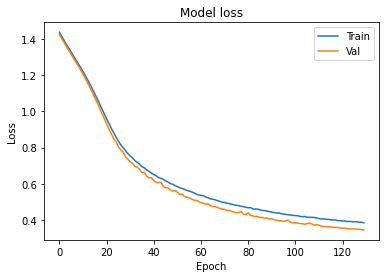

In [25]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
# plt.savefig('part8_loss_vs_epochs.png')
plt.show()

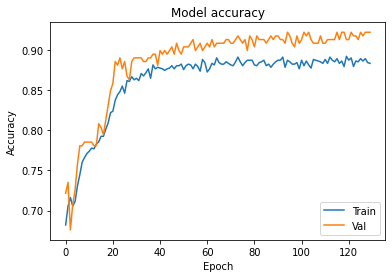

In [26]:
plt.plot(model_hist.history['acc'])
plt.plot(model_hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
# plt.savefig('part8_acc_vs_epochs.png')
plt.show()

In [27]:
model.evaluate(X_test,y_test)[1]

7/7 [==============================] - 0s 3ms/step - loss: 0.3153 - acc: 0.9041


0.9041095972061157

In [34]:
predictions = np.array([int(i>= 0.5) for i in model.predict(X_test)])

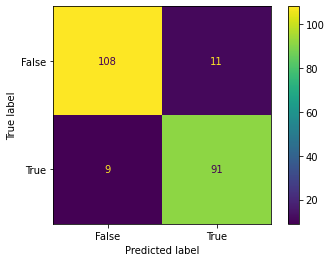

In [35]:
actual = y_test
confusion_matrix = metrics.confusion_matrix(actual, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.savefig('Confusion_matrix.png')